In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

In [203]:
sns.set_style("darkgrid")

# Modelling

## Prepare data

Import data from previous wrangle and profile stage

In [204]:
df_games = pd.read_csv('../data/merged_games.csv')

In [205]:
initial_columns = df_games.columns

In [206]:
if 'Unnamed: 0' in initial_columns:
    df_games.drop(columns=['Unnamed: 0'], axis='columns', inplace=True)

Take a look at the data again.

In [207]:
df_games.sample(5)

,Name,Release date,Estimated owners,Required age,Price,Supported languages,Windows,Mac,Linux,Metacritic score,...,Tags,Year,Month,Avg CCU,Gain,Peak,Avg_peak_ratio,Chart date,Categories Unchanged,Genres Unchanged
54090,Sakura Clicker,2015-07-29,1000000 - 2000000,0,0.00,['English'],True,False,False,0,...,"['Nudity', 'Anime', 'Free to Play', 'Sexual Co...",2019,November,123.32,32.24,180,68.5111%,2019-11-01,"['Single-player', 'Steam Trading Cards', 'Stea...","['Casual', 'Free to Play', 'Indie']"
58958,SteamWorld Dig,2013-12-05,500000 - 1000000,0,1.49,"['English', 'French', 'Italian', 'German', 'Sp...",True,True,True,76,...,"['Platformer', 'Mining', 'Steampunk', 'Indie',...",2014,July,54.15,-30.97,265,20.434%,2014-07-01,"['Single-player', 'Steam Achievements', 'Full ...","['Action', 'Adventure', 'Indie']"
13259,Cortex Command,2012-09-28,1000000 - 2000000,0,19.99,['English'],True,True,False,44,...,"['Strategy', 'Indie', 'Action', '2D', 'Physics...",2013,February,18.09,-4.79,51,35.4706%,2013-02-01,"['Single-player', 'Multi-player', 'Shared/Spli...","['Action', 'Indie', 'Strategy']"
50640,Resident Evil,2015-01-19,1000000 - 2000000,17,4.99,"['English', 'French', 'Italian', 'German', 'Sp...",True,False,False,82,...,"['Survival Horror', 'Zombies', 'Horror', 'Clas...",2017,August,121.53,-26.73,339,35.8496%,2017-08-01,"['Single-player', 'Steam Achievements', 'Full ...","['Action', 'Adventure']"
4505,Assetto Corsa,2014-12-19,2000000 - 5000000,0,19.99,"['English', 'Italian', 'Simplified Chinese', '...",True,False,False,85,...,"['Racing', 'Automobile Sim', 'Simulation', 'Dr...",2020,May,3858.29,-540.92,8153,47.3236%,2020-05-01,"['Single-player', 'Multi-player', 'PvP', 'Onli...","['Indie', 'Racing', 'Simulation', 'Sports']"


Check for anomalies in variables 'Avg CCU', 'Gain' und 'Peak' over the time with variable 'Chart date'.

In [208]:
modelling_columns = [
    'Avg CCU',
    'Gain',
    'Peak',
    'Chart date'
]

In [209]:
df_anomalies = df_games[modelling_columns].copy(deep=True).sort_values(by='Chart date', ascending=True)

In [210]:
df_anomalies.head(5)

,Avg CCU,Gain,Peak,Chart date
48948,356.18,0.0,605,2012-07-01
65087,1196.90,0.0,2006,2012-07-01
55002,23.01,0.0,57,2012-07-01
2091,347.42,0.0,568,2012-07-01
68577,249.96,0.0,469,2012-07-01


Group per charting month to see anomalies in peak ccu.

In [211]:
df_anomalies_grouped = df_anomalies.groupby(['Chart date'])[['Avg CCU', 'Gain', 'Peak']].sum().reset_index()

In [212]:
df_anomalies_grouped

,Chart date,Avg CCU,Gain,Peak
0,2012-07-01,415623.03,0.00,725923
1,2012-08-01,390093.56,-30494.05,767625
2,2012-09-01,429574.52,-56217.07,872222
3,2012-10-01,407905.89,-52551.55,971604
4,2012-11-01,456220.09,10541.70,1004920
...,...,...,...,...
99,2020-10-01,3655012.74,-83330.18,6926027
100,2020-11-01,3921445.27,143905.56,7394967
101,2020-12-01,4483348.22,209091.34,8572021
102,2021-01-01,4658179.68,139589.30,8371972


## Apply modelling with anomaly detection

In [213]:
def anomaly_check(columns: list, df: pd.DataFrame):
    for col in columns:
        model = IsolationForest(contamination=0.15)
        anomalies = model.fit_predict(df[[col]])

        df[f'Anomaly {col}'] = anomalies

    return df

In [214]:
interesting_columns = ['Avg CCU', 'Gain', 'Peak']

In [215]:
df_anomalies = anomaly_check(columns=interesting_columns, df=df_anomalies)

In [216]:
df_anomalies

,Avg CCU,Gain,Peak,Chart date,Anomaly Avg CCU,Anomaly Gain,Anomaly Peak
48948,356.18,0.00,605,2012-07-01,1,1,1
65087,1196.90,0.00,2006,2012-07-01,1,1,1
55002,23.01,0.00,57,2012-07-01,1,1,1
2091,347.42,0.00,568,2012-07-01,1,1,1
68577,249.96,0.00,469,2012-07-01,1,1,1
...,...,...,...,...,...,...,...
19657,2704.15,58.14,4684,2021-02-01,-1,1,-1
19700,19482.79,-1324.11,40203,2021-02-01,-1,-1,-1
19807,99.86,14.85,234,2021-02-01,1,1,1
19213,1477.37,110.65,4296,2021-02-01,-1,1,-1


Anomaly check on grouped data

In [217]:
df_anomalies_grouped = anomaly_check(columns=interesting_columns, df=df_anomalies_grouped)
df_anomalies_grouped

,Chart date,Avg CCU,Gain,Peak,Anomaly Avg CCU,Anomaly Gain,Anomaly Peak
0,2012-07-01,415623.03,0.00,725923,-1,1,-1
1,2012-08-01,390093.56,-30494.05,767625,-1,1,-1
2,2012-09-01,429574.52,-56217.07,872222,-1,1,-1
3,2012-10-01,407905.89,-52551.55,971604,-1,1,-1
4,2012-11-01,456220.09,10541.70,1004920,-1,1,1
...,...,...,...,...,...,...,...
99,2020-10-01,3655012.74,-83330.18,6926027,1,1,1
100,2020-11-01,3921445.27,143905.56,7394967,1,1,1
101,2020-12-01,4483348.22,209091.34,8572021,-1,-1,-1
102,2021-01-01,4658179.68,139589.30,8371972,-1,1,-1


In [218]:
df_anomalies_grouped = df_anomalies_grouped.loc[df_anomalies_grouped['Chart date'] >= '2017-01-01']

In [219]:
df_anomalies_grouped

,Chart date,Avg CCU,Gain,Peak,Anomaly Avg CCU,Anomaly Gain,Anomaly Peak
54,2017-01-01,2440263.92,157578.80,4738639,1,-1,1
55,2017-02-01,2406617.81,-34248.21,4625622,1,1,1
56,2017-03-01,2309208.76,-146246.09,4619231,1,1,1
57,2017-04-01,2361397.28,32877.24,4507854,1,1,1
58,2017-05-01,2333636.34,-38598.56,4431303,1,1,1
59,2017-06-01,2564468.88,213453.30,4968767,1,-1,1
60,2017-07-01,2687925.67,119502.01,4943753,1,1,1
61,2017-08-01,2804410.74,115332.53,5241160,1,1,-1
62,2017-09-01,2915996.25,107970.13,6086848,1,1,1
63,2017-10-01,3341904.39,414469.22,7025092,1,-1,1


## Visualize results from modelling

In [220]:
def transform_date_to_label(dates: list):
    transformed_dates = []

    for i, date in enumerate(dates):
        date = date[:-3]

        if i == 0:
            transformed_dates.append(date)
            continue

        if '-01' not in date:
            date = date[5:]
        
        transformed_dates.append(date)
    
    return transformed_dates

In [221]:
chart_dates = df_anomalies_grouped['Chart date']

chart_date_label = transform_date_to_label(chart_dates)

In [226]:
def draw_anomly_plot(df: pd.DataFrame, column: str, title: str, y_label: str):
    fig, ax = plt.subplots(figsize=(16,8))
    anomaly = df.loc[df[f'Anomaly {column}'] == -1, [column, 'Chart date']]
    sns.lineplot(data=df, x='Chart date', y=column, label=column)
    sns.scatterplot(data=anomaly, x='Chart date', y=column, label='Anomaly', markers=True, marker='o', s=100, c='red', zorder=5)

    plt.title(title, fontsize=16)
    plt.xlabel('Chart date')
    plt.xticks(rotation=90, ticks=chart_dates, labels=chart_date_label)
    plt.ylabel(y_label)
    #plt.yticks(ticks=range(x_min, x_max, 250000))
    plt.tight_layout()
    plt.legend(loc='upper left')
    plt.show()

Average concurrent player counts per month

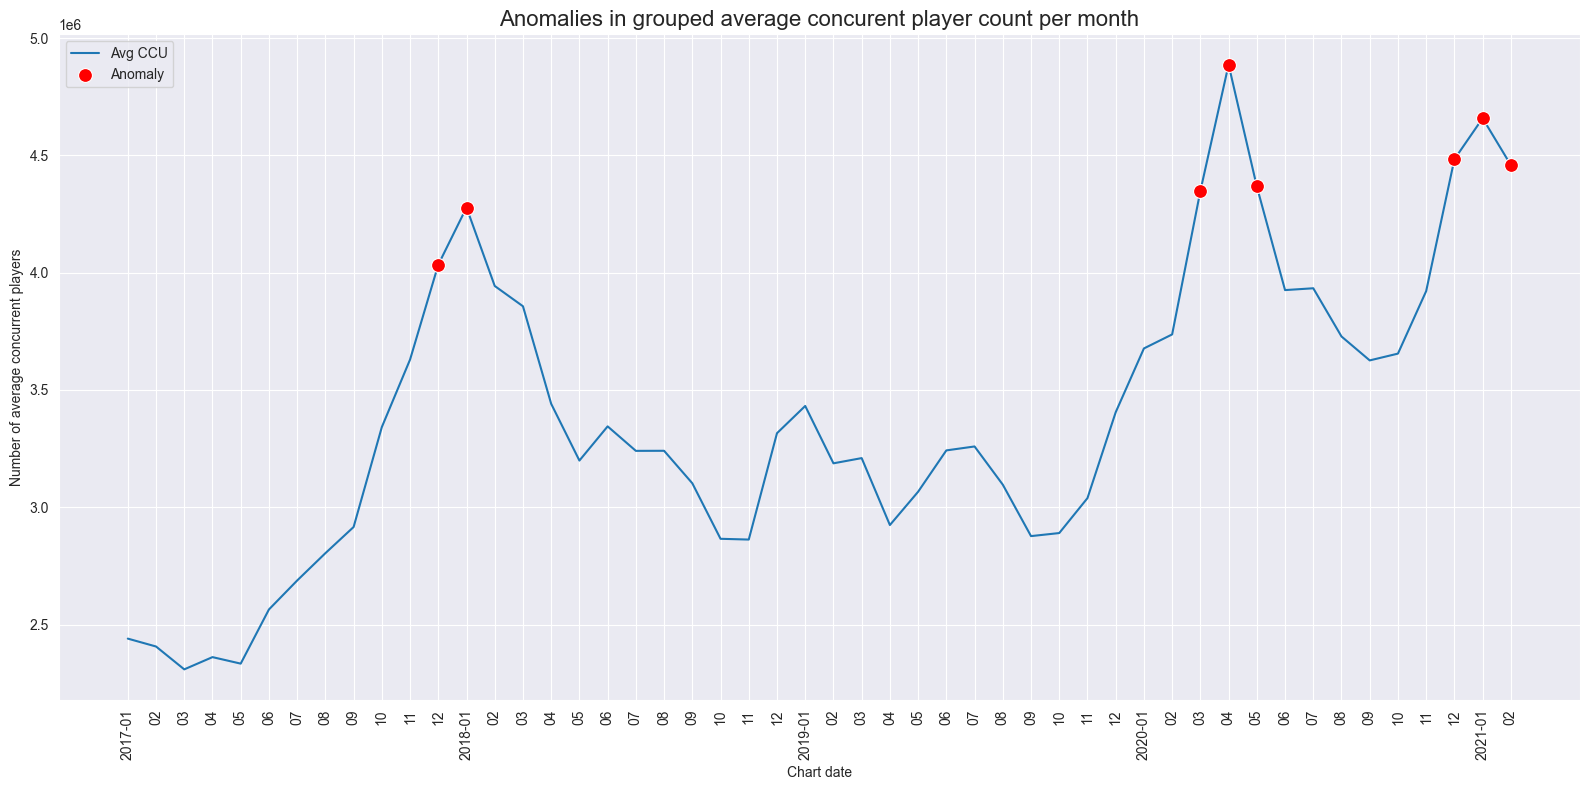

In [227]:
draw_anomly_plot(df_anomalies_grouped, 'Avg CCU', 'Anomalies in grouped average concurent player count per month', 'Number of average concurrent players')

Peak number of players per month

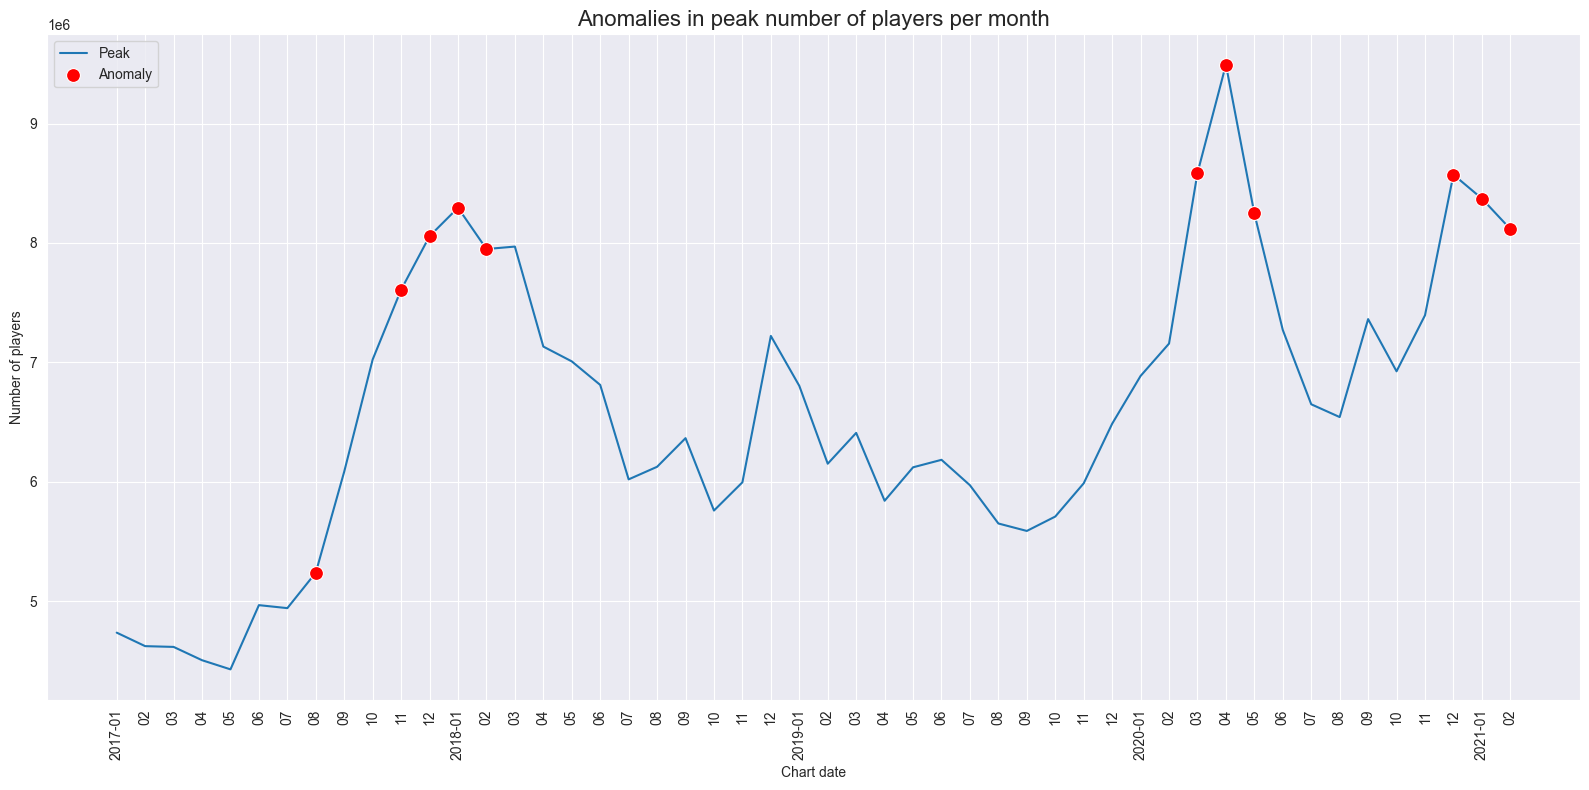

In [228]:
draw_anomly_plot(df_anomalies_grouped, 'Peak', 'Anomalies in peak number of players per month', 'Number of players')

Gain of player count per month

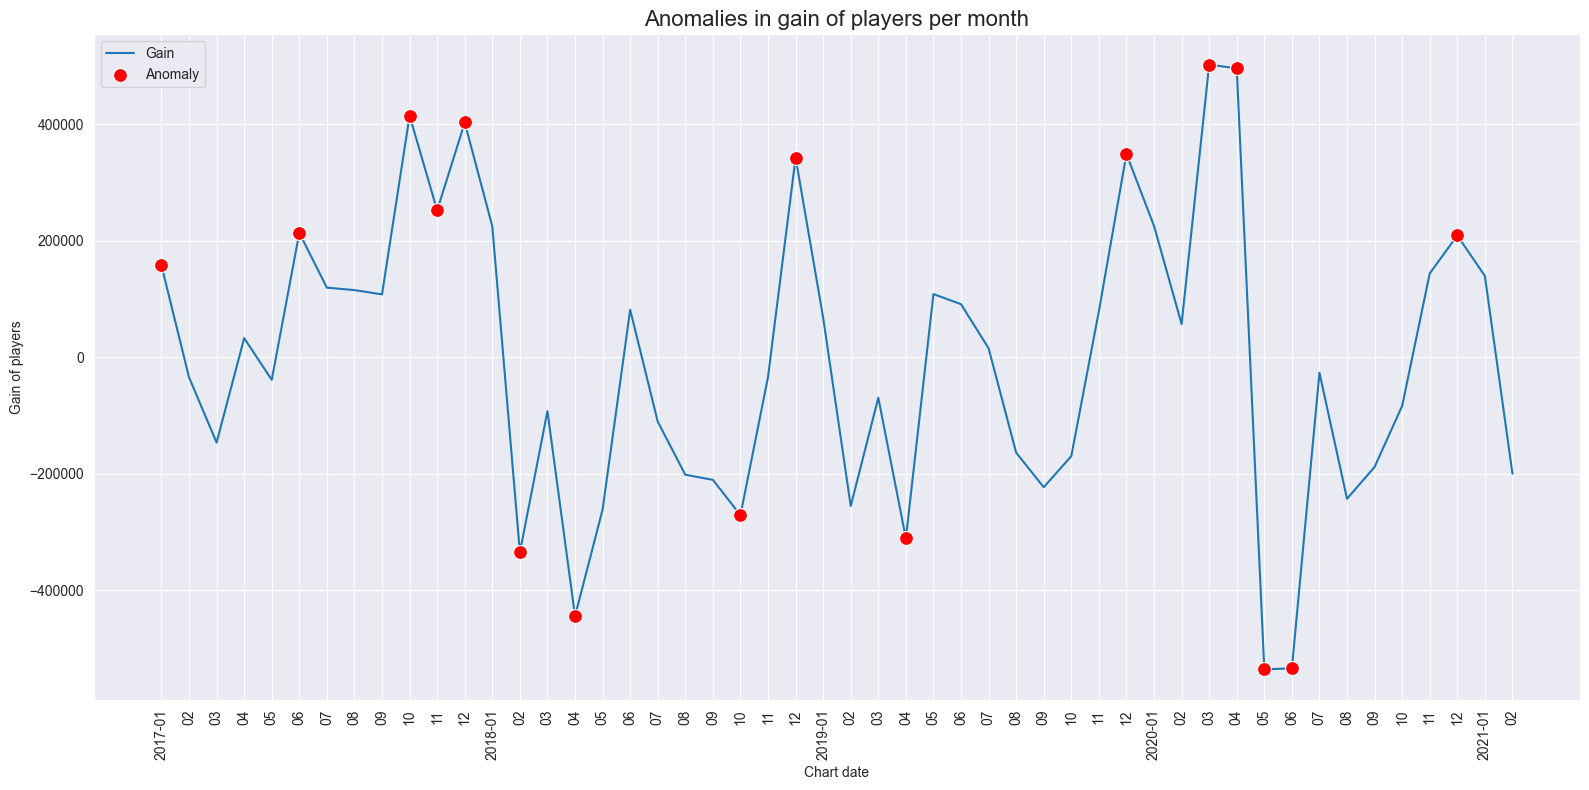

In [229]:
draw_anomly_plot(df_anomalies_grouped, 'Gain', 'Anomalies in gain of players per month', 'Gain of players')